<center>
<img src="https://github.com/oussou-dev/mlcourse.ai/blob/jupyter_french/img/ods_stickers.jpg?raw=true">
    

<br>

<div style="font-weight: 700; font-size: 25px;">[mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course
</div>


<br>


Auteur: [Yury Kashnitsky](https://yorko.github.io). Traduit et édité par [Christina Butsko](https://www.linkedin.com/in/christinabutsko/), [Nerses Bagiyan](https://www.linkedin.com/in/nersesbagiyan/), [Yulia Klimushina](https://www.linkedin.com/in/yuliya-klimushina-7168a9139), [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/) et [Ousmane Cissé](https://github.com/oussou-dev). Ce matériel est soumis aux termes et conditions de la licence [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). L'utilisation gratuite est autorisée à des fins non commerciales.</center>

# <center>Topic 4. Classification et régression linéaires
## <center> Partie 5. Courbes de validation et d'apprentissage</center></center>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve, learning_curve
from matplotlib import pyplot as plt

Maintenant que nous avons une idée de la validation du modèle, de la validation croisée et de la régularisation. Considérons la plus grande question:

**Que faire si la qualité du modèle est insatisfaisante?**

- Faut-il rendre le modèle plus compliqué ou plus simple?
- Faut-il ajouter plus de caractéristiques?
- Avons-nous simplement besoin de plus de données pour le training?

Les réponses à ces questions ne sont pas évidentes. En particulier, un modèle plus complexe peut parfois entraîner une dégradation des performances. D'autres fois, l'ajout de nouvelles observations n'apportera pas de changements notables. En fait, la capacité de prendre la bonne décision et de choisir la bonne méthode pour améliorer le modèle distingue un bon professionnel d’un mauvais.

Nous travaillerons nos données sur le taux d'attrition (churn) des clients de l'opérateur télécom

In [2]:
data = pd.read_csv('../../data/telecom_churn.csv').drop('State', axis=1)
data['International plan'] = data['International plan'].map({'Yes': 1, 'No': 0})
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1, 'No': 0})

y = data['Churn'].astype('int').values
X = data.drop('Churn', axis=1).values

**Nous allons entraîner la régression logistique avec une descente de gradient stochastique. Plus tard dans le cours, nous aurons un article séparé sur ce sujet.**

In [3]:
alphas = np.logspace(-2, 0, 20)
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17, max_iter=5)
logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), 
                       ('sgd_logit', sgd_logit)])
val_train, val_test = validation_curve(logit_pipe, X, y,
                                       'sgd_logit__alpha', alphas, cv=5,
                                       scoring='roc_auc')

**Dans un premier temps, nous allons construire des courbes de validation montrant comment la qualité (ROC-AUC) des données d'apprentissage et de test varie en fonction du paramètre de régularisation.**

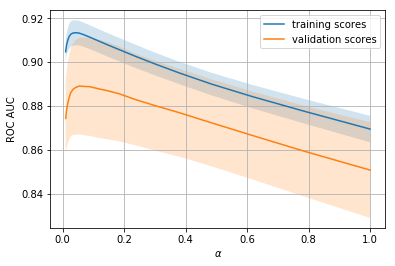

In [4]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True);

La tendance est assez visible et très commune.

- Pour les modèles simples, les erreurs d'apprentissage et de validation sont proches et importantes. Cela suggère que le modèle est **sous-ajusté**, ce qui signifie qu'il n'a pas un nombre suffisant de paramètres.

- Pour les modèles très sophistiqués, les erreurs d'apprentissage et de validation diffèrent considérablement. Ceci peut être expliqué par **overfitting**. Lorsqu'il y a trop de paramètres ou que la régularisation n'est pas assez stricte, l'algorithme peut être "distrait" par le bruit dans les données et perdre la trace de la tendance globale.

### Combien de données sont nécessaires?

Plus le modèle utilise de données, mieux c'est. Mais comment pouvons-nous savoir si de nouvelles données seront utiles dans une situation donnée? Par exemple, est-il rationnel de dépenser $N$ pour que les évaluateurs doublent l'ensemble de données?

Étant donné que les nouvelles données peuvent être indisponibles, il est raisonnable de faire varier la taille du training set et de voir comment la qualité de la solution dépend de la quantité de données d'entraînement. C’est ainsi que nous obtenons les **courbes d’apprentissage**.

L'idée est simple: nous affichons l'erreur en fonction du nombre d'exemples utilisés en formation. Les paramètres du modèle sont fixés à l'avance.

In [5]:
def plot_learning_curve(degree=2, alpha=0.01):
    train_sizes = np.linspace(0.05, 1, 20)
    logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=degree)), 
                           ('sgd_logit', SGDClassifier(n_jobs=-1, random_state=17, alpha=alpha, max_iter=5))])
    N_train, val_train, val_test = learning_curve(logit_pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()
    plt.grid(True);

Voyons ce que nous obtenons pour le modèle linéaire. Nous allons définir le coefficient de régularisation sur assez grand.

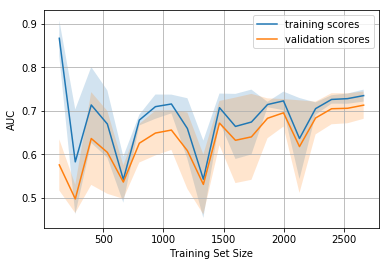

In [6]:
plot_learning_curve(degree=2, alpha=10)

Une situation typique: pour une petite quantité de données, les erreurs entre les ensembles d'apprentissage et de validation croisée sont assez différentes, indiquant un surajustement. Pour ce même modèle, mais avec une grande quantité de données, les erreurs "convergent", ce qui indique un sous-apprentissage.
 
Si nous ajoutons plus de données, les erreurs sur l'ensemble d'apprentissage ne vont pas augmenter. D'autre part, l'erreur sur les données de test ne sera pas réduite.
 
Donc, nous voyons que les erreurs "ont convergé", et l'ajout de nouvelles données ne va pas aider. En fait, cette affaire est la plus intéressante pour les entreprises. Il est possible que nous augmentions la taille de l'ensemble de données de 10 fois, mais, sans changer la complexité du modèle, ces données supplémentaires risquent de ne pas aider. Par conséquent, la stratégie "Définir une fois, puis utiliser 10 fois" risque de ne pas fonctionner.
 
Que se passe-t-il si nous réduisons le coefficient de régularisation à 0,05?
 
Nous voyons une bonne tendance - les courbes convergent progressivement et si nous allons plus à droite, c’est-à-dire si nous ajoutons plus de données au modèle, nous pourrons encore améliorer la qualité du jeu de validation.

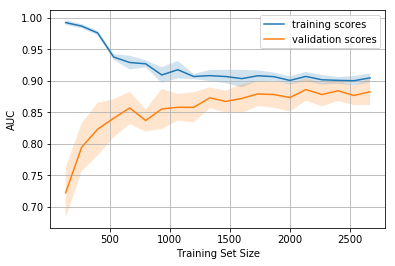

In [7]:
plot_learning_curve(degree=2, alpha=0.05)

Et si nous rendions le modèle encore plus complexe en définissant alpha = 10-4?

On constate un surajustement - AUC diminue à la fois dans les ensembles d'apprentissage et de validation.

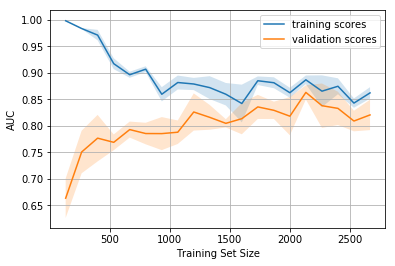

In [8]:
plot_learning_curve(degree=2, alpha=1e-4)

La construction de ces courbes peut aider à comprendre le chemin à parcourir et la manière de régler correctement la complexité du modèle pour les nouvelles données.

**Conclusions sur les courbes d'apprentissage et de validation:**


- Une erreur sur le training set ne dit rien sur la qualité du modèle en soi
- Une erreur de validation croisée montre dans quelle mesure le modèle adapte les données (la tendance existante dans les données) tout en conservant la possibilité de généraliser à de nouvelles données.
- **La courbe de validation** est un graphique montrant les résultats des données d'entraînement et de validation en fonction de la complexité **du modèle**:
    + si les deux courbes sont proches l'une de l'autre et que les deux erreurs sont importantes, c'est un signe de *sous-ajustement*
    + si les deux courbes sont éloignées l'une de l'autre, c'est un signe de *overfitting*
- **courbe d’apprentissage** est un graphique montrant les résultats des données d'entraînement et de validation en fonction du nombre d’observations:
    + si les courbes convergent, l'ajout de nouvelles données ne va pas aider, et il est nécessaire de changer la complexité du modèle
    + si les courbes n'ont pas convergé, l'ajout de nouvelles données peut améliorer le résultat

### Ressources utiles
- Main course [site](https://mlcourse.ai), [course repo](https://github.com/Yorko/mlcourse.ai), and YouTube [channel](https://www.youtube.com/watch?v=QKTuw4PNOsU&amp;list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
- Medium ["story"](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-4-linear-classification-and-regression-44a41b9b5220) based on this notebook
- Course materials as a [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
- If you read Russian: an [article](https://habrahabr.ru/company/ods/blog/323890/) on Habrahabr with ~ the same material. And a [lecture](https://youtu.be/oTXGQ-_oqvI) on YouTube
- A nice and concise overview of linear models is given in the book [“Deep Learning”](http://www.deeplearningbook.org) (I. Goodfellow, Y. Bengio, and A. Courville).
- Linear models are covered practically in every ML book. We recommend “Pattern Recognition and Machine Learning” (C. Bishop) and “Machine Learning: A Probabilistic Perspective” (K. Murphy).
- If you prefer a thorough overview of linear model from a statistician’s viewpoint, then look at “The elements of statistical learning” (T. Hastie, R. Tibshirani, and J. Friedman).
- The book “Machine Learning in Action” (P. Harrington) will walk you through implementations of classic ML algorithms in pure Python.
- [Scikit-learn](http://scikit-learn.org/stable/documentation.html) library. These guys work hard on writing really clear documentation.
- Scipy 2017 [scikit-learn tutorial](https://github.com/amueller/scipy-2017-sklearn) by Alex Gramfort and Andreas Mueller.
- One more [ML course](https://github.com/diefimov/MTH594_MachineLearning) with very good materials.
- [Implementations](https://github.com/rushter/MLAlgorithms) of many ML algorithms. Search for linear regression and logistic regression.